In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import statistics
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pymc3
import theano.tensor as tt
import arviz as az
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import accuracy_score, recall_score ,precision_score, f1_score

In [8]:
stroke_df = pd.read_csv('healthcare-dataset-stroke-data.csv')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [9]:
stroke_df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

<h1>##Data pre-processing

In [10]:
stroke_df.drop(columns=['id'],inplace=True)

In [11]:
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [12]:
stroke_df.shape


(5110, 11)

In [13]:
length=len(stroke_df)
def calculate_missing_values(df, name):
    df = df.isna().sum().to_frame().reset_index().rename({'index': 'feature', 0: name}, axis=1)
    df[name] = round(df[name]/length*100, 2)
    return df
    
miss_val_table = calculate_missing_values(stroke_df, '% of missing data')
    
miss_val_table = miss_val_table.style.hide_index().set_table_styles([
        {'selector': 'th.col_heading', 'props': 'font-size: 11pt; text-align: center; font-weight: bold; border: 1px solid white !important'},
       {'selector': 'td', 'props': 'text-align: center; font-size: 10pt; border: 1px solid black !important'},
        {'selector': 'th:not(.index_name)', 'props': 'background-color: #000066; color: white;'}
        ], overwrite=False).set_properties(subset=['feature'], **{'font-weight': 'bold'})
miss_val_table

C:\Users\Sahil\AppData\Local\Temp\ipykernel_18700\1042933079.py:9: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  miss_val_table = miss_val_table.style.hide_index().set_table_styles([


feature,% of missing data
gender,0.000000
age,0.000000
hypertension,0.000000
heart_disease,0.000000
ever_married,0.000000
work_type,0.000000
Residence_type,0.000000
avg_glucose_level,0.000000
bmi,3.930000
smoking_status,0.000000


In [16]:
stroke_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.885636,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.698109,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [14]:
stroke_df['bmi'].fillna(stroke_df['bmi'].mode()[0], inplace=True)

In [15]:
stroke_df['bmi'].isna().sum()

0

In [17]:
#checking categorical values
stroke_df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [18]:
stroke_df['Residence_type'].unique()


array(['Urban', 'Rural'], dtype=object)

In [19]:
stroke_df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [20]:
stroke_df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [21]:
stroke_df['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

In [22]:
stroke_df['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

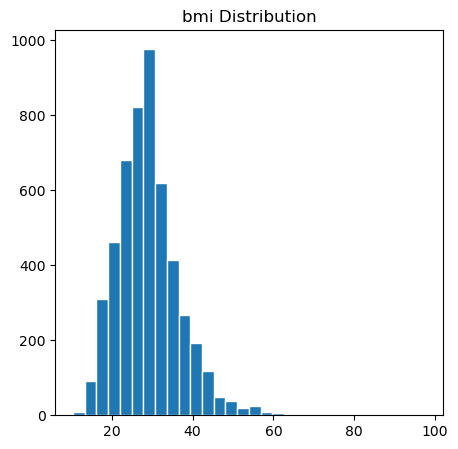

In [24]:
plt.figure(figsize=(5, 5))
plt.hist(stroke_df['bmi'],bins=30,edgecolor="white")
plt.title("bmi Distribution")
plt.show()

In [25]:
#outlier detection
def outliers_detection(df, features):
    # Empty list to store indices of outliers
    outlier_indices = []
    for feature in features:
        # Calculate the first quartile
        Q1 = np.percentile(df[feature], 25)
        # Calculate the third quartile
        Q3 = np.percentile(df[feature], 75)
        # Calculate the interquartile range
        IQR = Q3 - Q1
        # Calculate the outlier step
        outlier_step = IQR * 1.5
        # Identify outliers and their indices
        outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        # Store the indices of the outliers
        outlier_indices.extend(outlier_list_col)
    # Use Counter to count the number of occurrences of each index
    outlier_indices = Counter(outlier_indices)
    # Create a list of indices for rows with more than 2 outliers
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    return multiple_outliers


In [26]:
list_of_cols=['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']
stroke_df.loc[outliers_detection(stroke_df,list_of_cols)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
13,Male,78.0,0,1,Yes,Private,Urban,219.84,28.7,Unknown,1
14,Female,79.0,0,1,Yes,Private,Urban,214.09,28.2,never smoked,1
16,Male,64.0,0,1,Yes,Private,Urban,191.61,37.5,smokes,1
...,...,...,...,...,...,...,...,...,...,...,...
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
35,Female,82.0,1,1,No,Private,Rural,84.03,26.5,formerly smoked,1
143,Female,69.0,1,1,No,Self-employed,Urban,72.17,36.8,never smoked,1
171,Female,79.0,1,1,No,Self-employed,Rural,60.94,28.7,never smoked,1


In [27]:
stroke_df.drop(outliers_detection(stroke_df,list_of_cols),axis = 0).reset_index(drop = True, inplace=True)

In [28]:
#filling missing values
female_mode_bmi = stroke_df[stroke_df['gender'] == 'Female']['bmi'].median()
male_mode_bmi = stroke_df[stroke_df['gender'] == 'Male']['bmi'].median()
overall_mode_bmi = stroke_df['bmi'].median()
print(f"Median of BMI value for Females: {female_mode_bmi:.2f}")
print(f"Median of BMI value for Males: {male_mode_bmi:.2f}")
print(f"Median of BMI value: {overall_mode_bmi:.2f}")

Median of BMI value for Females: 28.10
Median of BMI value for Males: 28.70
Median of BMI value: 28.40


In [29]:
for i in range(0,length):
    if(stroke_df['bmi'][i] == 0):
        if(stroke_df['gender'][i] == 'Male'):
            stroke_df['bmi'][i] = 28.10
        elif(stroke_df['gender'][i] == 'Female'):
            stroke_df['bmi'][i] = 28.70
        else:
            stroke_df['bmi'][i] = 28.40

<h1>##EDA

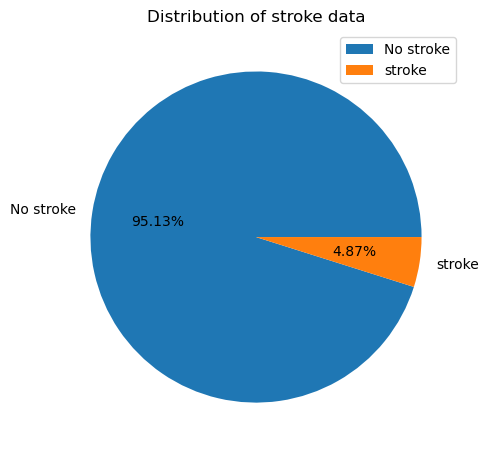

In [23]:
#distribution of stroke data
plt.figure(figsize = (5, 5))
plt.pie(pd.value_counts(stroke_df['stroke']), 
        labels = ['No stroke','stroke'], autopct='%2.2f%%',)
plt.legend()
plt.title('Distribution of stroke data')
plt.tight_layout()
plt.show()

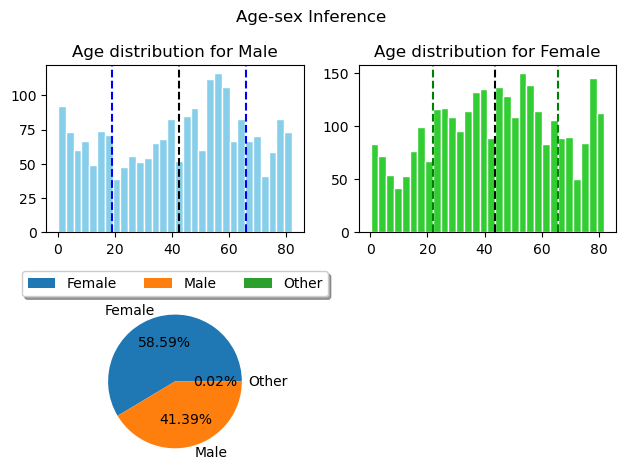

In [30]:
#age-sex inference
male_age_dist=stroke_df[stroke_df['gender']=='Male']
female_age_dist=stroke_df[stroke_df['gender']=='Female']

#plt.style.use('seaborn')
plt.suptitle('Age-sex Inference')
plt.subplot(2,2,1)
plt.hist(male_age_dist['age'],bins=30,edgecolor="white",color="skyblue")
male_mean=statistics.mean(male_age_dist['age'])
male_sd=statistics.stdev(male_age_dist['age'])
plt.axvline(male_mean,color='k',linestyle='dashed')
plt.axvline(male_mean+male_sd,color='b',linestyle='dashed')
plt.axvline(male_mean-male_sd,color='b',linestyle='dashed')
plt.title("Age distribution for Male")


plt.subplot(2,2,2)
plt.hist(female_age_dist['age'],bins=30,edgecolor="white",color="limegreen")
plt.title("Age distribution for Female")
female_mean=statistics.mean(female_age_dist['age'])
female_sd=statistics.stdev(female_age_dist['age'])
plt.axvline(female_mean,color='k',linestyle='dashed')
plt.axvline(female_mean+female_sd,color='g',linestyle='dashed')
plt.axvline(female_mean-female_sd,color='g',linestyle='dashed')

plt.subplot(2,2,3)
ax = plt.subplot(2,2,3)
plt.pie(stroke_df['gender'].value_counts(),labels=['Female','Male','Other'],autopct='%2.2f%%')
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

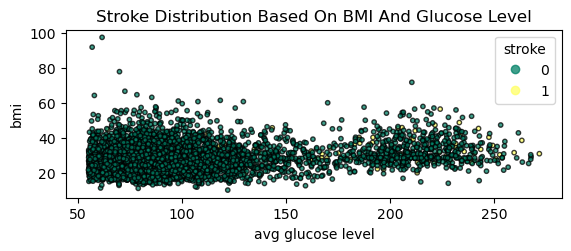

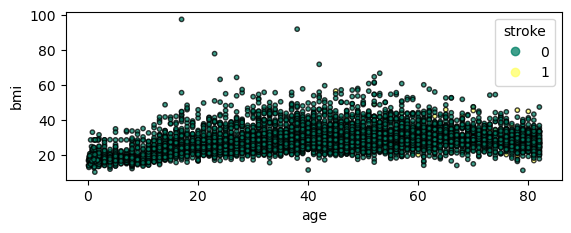

<Figure size 640x480 with 0 Axes>

In [31]:
#scatter plot
plt.subplot(2,1,1)
plt.title('Stroke Distribution Based On BMI And Glucose Level')
strokes=stroke_df['stroke']

scatter=plt.scatter(stroke_df['avg_glucose_level'],stroke_df['bmi'],c=strokes,s=10, cmap='summer',edgecolor='black', linewidth=1, alpha=0.75)
plt.xlabel('avg glucose level')
plt.ylabel('bmi')
plt.legend(*scatter.legend_elements(),title='stroke')
plt.show()

plt.subplot(2,1,2)
scatter=plt.scatter(stroke_df['age'],stroke_df['bmi'],c=strokes, cmap='summer',s=10,edgecolor='black', linewidth=1, alpha=0.75)
plt.xlabel('age')
plt.ylabel('bmi')
plt.legend(*scatter.legend_elements(),title='stroke')
plt.show()
plt.tight_layout()
plt.show()


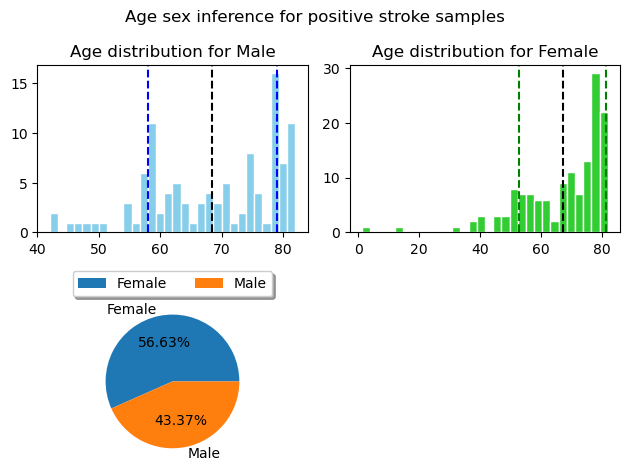

In [32]:
#Age sex inference for stroke positive samples
positive_samples=stroke_df[stroke_df['stroke']==1]
male_age_dist_positive=positive_samples[positive_samples['gender']=='Male']
female_age_dist_positive=positive_samples[positive_samples['gender']=='Female']


plt.suptitle('Age sex inference for positive stroke samples')
plt.subplot(2,2,1)
plt.hist(male_age_dist_positive['age'],bins=30,edgecolor="white",color="skyblue")
male_mean=statistics.mean(male_age_dist_positive['age'])
male_sd=statistics.stdev(male_age_dist_positive['age'])
plt.axvline(male_mean,color='k',linestyle='dashed')
plt.axvline(male_mean+male_sd,color='b',linestyle='dashed')
plt.axvline(male_mean-male_sd,color='b',linestyle='dashed')
plt.title("Age distribution for Male")


plt.subplot(2,2,2)
plt.hist(female_age_dist_positive['age'],bins=30,edgecolor="white",color="limegreen")
plt.title("Age distribution for Female")
female_mean=statistics.mean(female_age_dist_positive['age'])
female_sd=statistics.stdev(female_age_dist_positive['age'])
plt.axvline(female_mean,color='k',linestyle='dashed')
plt.axvline(female_mean+female_sd,color='g',linestyle='dashed')
plt.axvline(female_mean-female_sd,color='g',linestyle='dashed')

plt.subplot(2,2,3)
ax = plt.subplot(2,2,3)
plt.pie(positive_samples['gender'].value_counts(),labels=['Female','Male'],autopct='%2.2f%%')
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

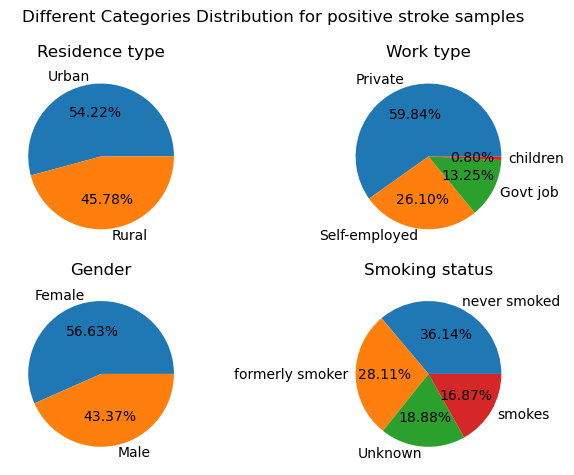

In [33]:
#for different categorical values
plt.suptitle('Different Categories Distribution for positive stroke samples')
plt.subplot(2,2,1)
ax = plt.subplot(2,2,1)
plt.pie(positive_samples['Residence_type'].value_counts(),labels=['Urban','Rural'],autopct='%2.2f%%')

plt.title('Residence type')

plt.subplot(2,2,2)
ax = plt.subplot(2,2,2)
plt.pie(positive_samples['work_type'].value_counts(),labels=['Private','Self-employed','Govt job','children'],autopct='%2.2f%%')
plt.title('Work type')

plt.subplot(2,2,3)
ax = plt.subplot(2,2,3)
plt.pie(positive_samples['gender'].value_counts(),labels=['Female','Male'],autopct='%2.2f%%')
plt.title('Gender')

plt.subplot(2,2,4)
ax = plt.subplot(2,2,4)
plt.pie(positive_samples['smoking_status'].value_counts(),labels=['never smoked','formerly smoker','Unknown','smokes'],autopct='%2.2f%%')

plt.title('Smoking status')
plt.tight_layout()

plt.show()

<AxesSubplot:>

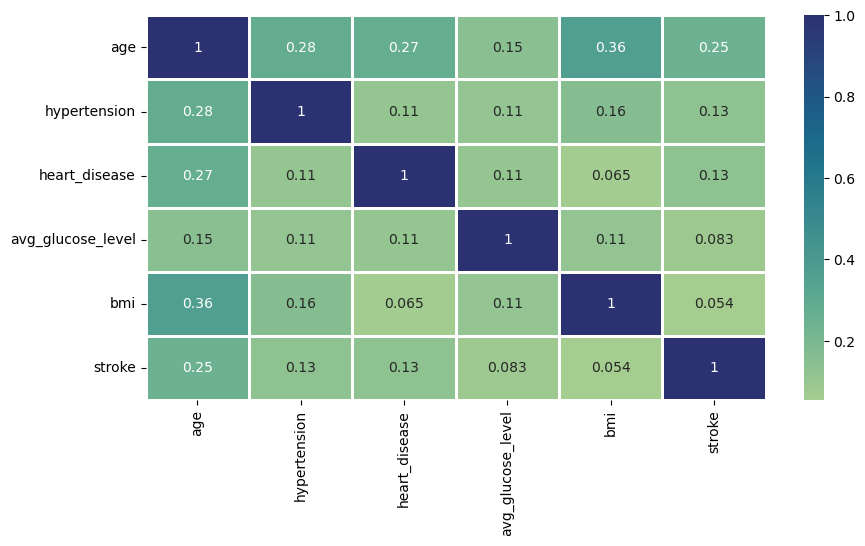

In [34]:
#correlation for cols with numerical values
plt.figure(figsize=(10,5)) 
corr = stroke_df.corr(method = 'spearman')
sns.heatmap(corr, annot = True,cmap='crest', linewidths = 2)

In [35]:
##https://medium.com/analytics-vidhya/handling-imbalanced-data-by-oversampling-with-smote-and-its-variants-23a4bf188eaf
input_d = stroke_df.drop('stroke', axis=1).values
output_d= stroke_df['stroke'].values

transform_cols = ColumnTransformer([('encoder', OneHotEncoder(), [0,4,5,6,9])], remainder='passthrough')
encoded_data=transform_cols.fit_transform(input_d)


#scaling numerical features
scale_feat = ColumnTransformer([('scale_feat', StandardScaler(), [16, 19, 20])], remainder='passthrough')
final_input = scale_feat.fit_transform(encoded_data)

In [36]:
final_input[0]

array([1.0514342842814732, 2.7063754415827868, 1.0022095609082973, 0.0,
       1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0,
       0.0, 0.0, 0, 1], dtype=object)

In [37]:
#train-test split
train_data_X,test_data_X, train_data_y, test_data_y = train_test_split(final_input, output_d, test_size=0.3)
eval_X, test_data_X, eval_y, test_data_y = train_test_split(test_data_X, test_data_y, test_size=0.4)

In [41]:
print('Samples in Train Set:', len(train_data_X))
print('Samples in Validation Set:', len(eval_X))
print('Samples in Test Set:', len(test_data_X))

Samples in Train Set: 3577
Samples in Validation Set: 919
Samples in Test Set: 614


In [42]:
#upsampling
oversample = BorderlineSMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(train_data_X, train_data_y)
X_eval_resampled, y_eval_resampled = oversample.fit_resample(eval_X, eval_y)

print('Intitial dataset "stroke" Percent :', train_data_y.sum()/len(train_data_y))
print('Balanced dataset "stroke" Percent :', y_train_resampled.sum()/len(y_train_resampled))

Intitial dataset "stroke" Percent : 0.047525859658932065
Balanced dataset "stroke" Percent : 0.5


In [43]:
#building a NN model
train_data_X.shape

(3577, 21)

In [44]:
#mlp
inputs = keras.Input(shape=(21,))
hidden1 = layers.Dense(32, activation='relu')(inputs)
hidden2 = layers.Dropout(0.7)(hidden1)
hidden3 = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(hidden2)
hidden4 = layers.BatchNormalization()(hidden3)
hidden5 = layers.Dropout(0.7)(hidden4)
hidden6 = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(hidden5)
hidden7 = layers.BatchNormalization()(hidden6)
hidden8 = layers.Dropout(0.7)(hidden7)
hidden9 = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(hidden8)
hidden10 = layers.BatchNormalization()(hidden9)
hidden11 = layers.Dropout(0.7)(hidden10)
concat = layers.concatenate([hidden1, hidden11])
hidden12 = layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(concat)
hidden13 = layers.BatchNormalization()(hidden12)
hidden14 = layers.Dropout(0.7)(hidden13)
output = layers.Dense(1, activation='sigmoid')(hidden14)

mlp_model = keras.Model(inputs, output, name="stroke_predictor")
mlp_model.summary()



Model: "stroke_predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           704         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 32)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 64)           2112        ['dropout[0][0]']                
                                                                                   

In [45]:
mlp_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy', metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
epochs = 1000
batch_size = 32
stroke_predictor_history = mlp_model.fit(x=X_train_resampled, y=y_train_resampled, batch_size=batch_size,
                    epochs=epochs, callbacks=es_callback, validation_data=(X_eval_resampled, y_eval_resampled),
                    verbose=0)

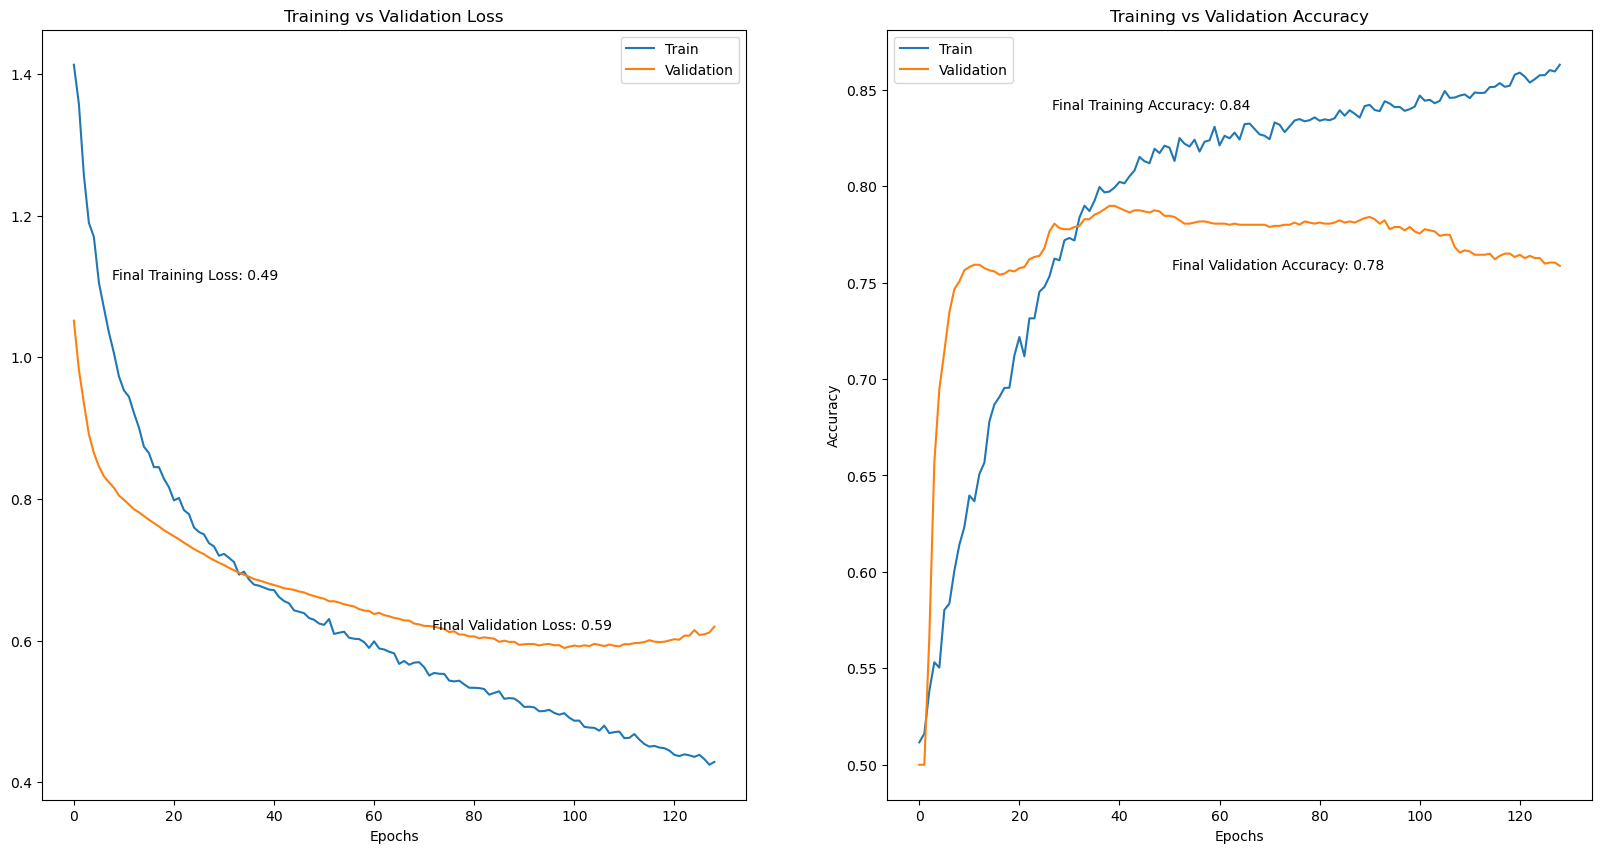

In [47]:
#plots the training vs validation loss and accuracy
fig = plt.figure(figsize=(20, 10))

a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)

a1.set_title('Training vs Validation Loss')
a1.set_xlabel('Epochs')
a2.set_ylabel('Loss')
a1.plot(stroke_predictor_history.history['loss'], label='Train')
a1.plot(stroke_predictor_history.history['val_loss'], label='Validation')
a1.legend()

fig.text(0.16, 0.63, 'Final Training Loss: ' + str(round(stroke_predictor_history.history['loss'][-30], 2)))
fig.text(0.32, 0.28, 'Final Validation Loss: ' + str(round(stroke_predictor_history.history['val_loss'][-30], 2)) )

a2.set_title('Training vs Validation Accuracy')
a2.set_xlabel('Epochs')
a2.set_ylabel('Accuracy')
a2.plot(stroke_predictor_history.history['accuracy'], label='Train')
a2.plot(stroke_predictor_history.history['val_accuracy'], label='Validation')
a2.legend()

fig.text(0.63, 0.80, 'Final Training Accuracy: ' + str(round(stroke_predictor_history.history['accuracy'][-30], 2)))
fig.text(0.69, 0.64, 'Final Validation Accuracy: ' + str( round(stroke_predictor_history.history['val_accuracy'][-30], 2)) )
plt.show()

In [58]:

# Convert test data to a tensor
test_data_X_tensor = tf.convert_to_tensor(test_data_X, dtype=tf.float32)
predictions = mlp_model.predict(test_data_X_tensor)
threshold = 0.5
binary_test_data_y = np.array([1 if i > threshold else 0 for i in test_data_y])
binary_predictions = [1 if i > threshold else 0 for i in predictions]
accuracy = accuracy_score(binary_test_data_y, binary_predictions)
recall = recall_score(binary_test_data_y, binary_predictions)
precision = precision_score(binary_test_data_y, binary_predictions)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)

20/20 [==============================] - 0s 2ms/step
Accuracy: 0.7817589576547231
Recall: 0.8214285714285714
Precision: 0.1513157894736842


In [108]:
X_train_resampled.shape


(6814, 21)

In [113]:

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(units=128, input_shape=(21, 1), return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units=64, return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units=32))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
stroke_predictor_history_rnn = rnn_model.fit(x=X_train_resampled, y=y_train_resampled, epochs=10, validation_data=(X_eval_resampled, y_eval_resampled))


Epoch 1/10
213/213 [==============================] - 18s 55ms/step - loss: 0.4962 - accuracy: 0.7618 - val_loss: 0.4481 - val_accuracy: 0.7765
Epoch 2/10
213/213 [==============================] - 10s 47ms/step - loss: 0.4339 - accuracy: 0.8083 - val_loss: 0.4525 - val_accuracy: 0.7707
Epoch 3/10
213/213 [==============================] - 10s 48ms/step - loss: 0.4215 - accuracy: 0.8177 - val_loss: 0.5418 - val_accuracy: 0.6861
Epoch 4/10
213/213 [==============================] - 11s 50ms/step - loss: 0.4201 - accuracy: 0.8189 - val_loss: 0.4473 - val_accuracy: 0.7702
Epoch 5/10
213/213 [==============================] - 9s 43ms/step - loss: 0.4121 - accuracy: 0.8221 - val_loss: 0.4378 - val_accuracy: 0.7725
Epoch 6/10
213/213 [==============================] - 9s 43ms/step - loss: 0.4048 - accuracy: 0.8262 - val_loss: 0.4443 - val_accuracy: 0.7707
Epoch 7/10
213/213 [==============================] - 9s 40ms/step - loss: 0.4038 - accuracy: 0.8239 - val_loss: 0.4441 - val_accuracy: 0.

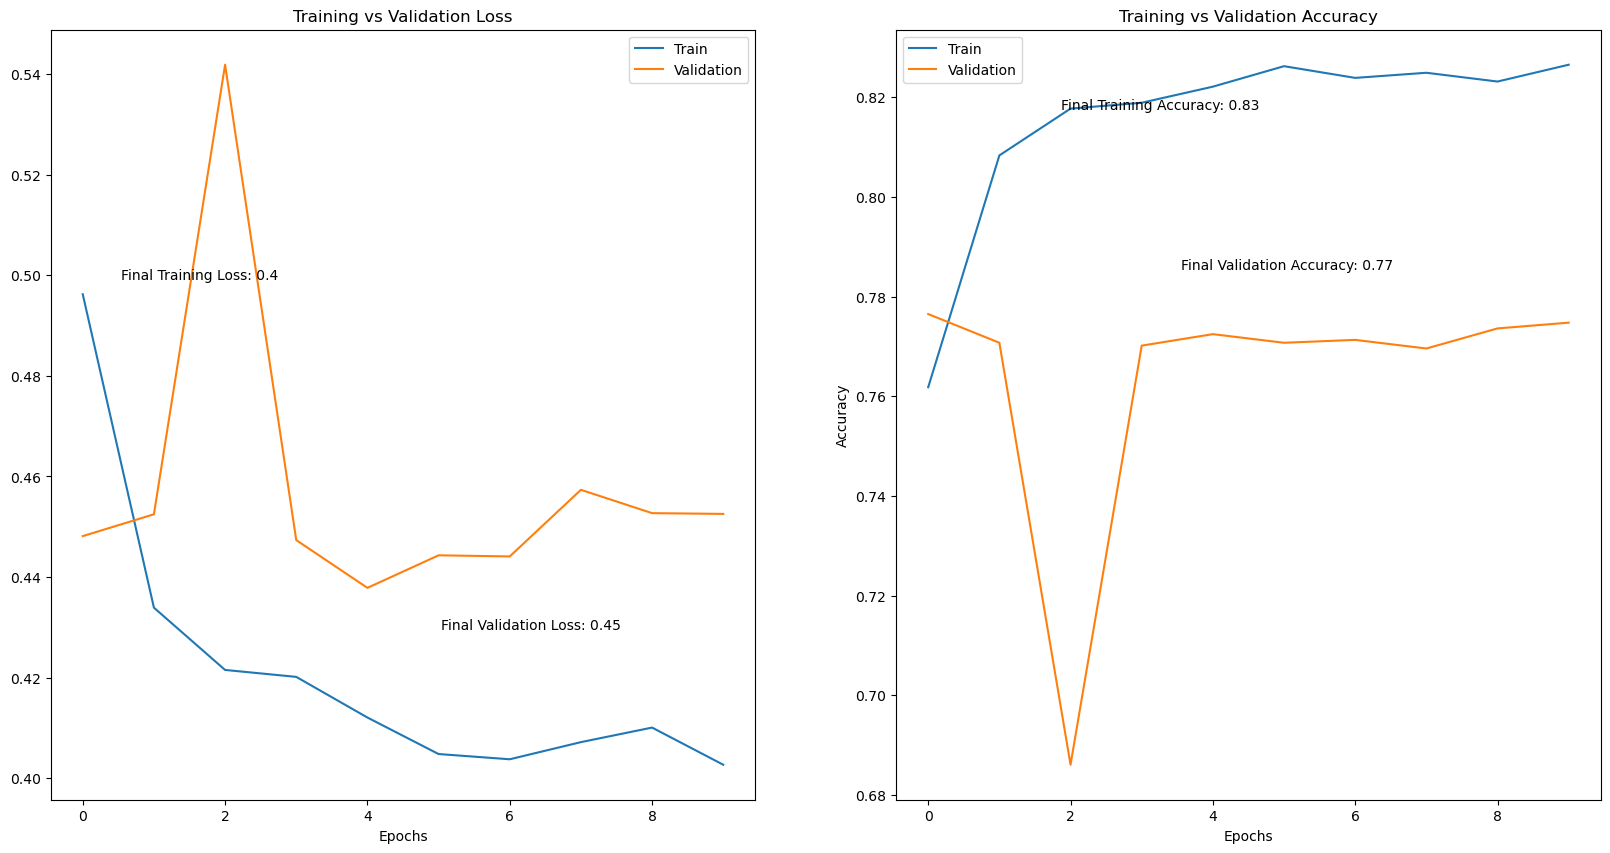

In [122]:
fig = plt.figure(figsize=(20, 10))

a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)

a1.set_title('Training vs Validation Loss')
a1.set_xlabel('Epochs')
a2.set_ylabel('Loss')
a1.plot(stroke_predictor_history_rnn.history['loss'], label='Train')
a1.plot(stroke_predictor_history_rnn.history['val_loss'], label='Validation')
a1.legend()

fig.text(0.16, 0.63, 'Final Training Loss: ' + str(round(stroke_predictor_history_rnn.history['loss'][-1], 2)))
fig.text(0.32, 0.28, 'Final Validation Loss: ' + str(round(stroke_predictor_history_rnn.history['val_loss'][-1], 2)) )

a2.set_title('Training vs Validation Accuracy')
a2.set_xlabel('Epochs')
a2.set_ylabel('Accuracy')
a2.plot(stroke_predictor_history_rnn.history['accuracy'], label='Train')
a2.plot(stroke_predictor_history_rnn.history['val_accuracy'], label='Validation')
a2.legend()

fig.text(0.63, 0.80, 'Final Training Accuracy: ' + str(round(stroke_predictor_history_rnn.history['accuracy'][-1], 2)))
fig.text(0.69, 0.64, 'Final Validation Accuracy: ' + str( round(stroke_predictor_history_rnn.history['val_accuracy'][-1], 2)) )
plt.show()

In [117]:
test_data_X_tensor = tf.convert_to_tensor(test_data_X, dtype=tf.float32)
predictions = rnn_model.predict(test_data_X_tensor)
threshold = 0.5
binary_test_data_y = np.array([1 if i > threshold else 0 for i in test_data_y])
binary_predictions = [1 if i > threshold else 0 for i in predictions]
accuracy = accuracy_score(binary_test_data_y, binary_predictions)
recall = recall_score(binary_test_data_y, binary_predictions)
precision = precision_score(binary_test_data_y, binary_predictions)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)

20/20 [==============================] - 2s 18ms/step
Accuracy: 0.7833876221498371
Recall: 0.8928571428571429
Precision: 0.16129032258064516
